In [284]:
def filter_columns_and_indexes(
    df: pd.DataFrame,
    keep_columns: Union[list, str],
    drop_columns: Union[list, str],
    keep_indexes: Union[list, str],
    drop_indexes: Union[list, str],
    drop_before_keep: bool = False
):
    """
    Filters a DataFrame based on specified columns and indexes.

    Parameters:
    df (pd.DataFrame): DataFrame to be filtered.
    keep_columns (list or str): Columns to keep in the DataFrame.
    drop_columns (list or str): Columns to drop from the DataFrame.
    keep_indexes (list or str): Indexes to keep in the DataFrame.
    drop_indexes (list or str): Indexes to drop from the DataFrame.
    drop_before_keep (bool, default=False): Whether to drop specified columns/indexes before keeping.

    Returns:
    pd.DataFrame: The filtered DataFrame.
    """
    if not isinstance(df, (pd.DataFrame, pd.Series)):
        return df
    df = df.copy()
    # Columns
    if keep_columns is not None:
        keep_columns = "(?i)" + "|".join(keep_columns) if isinstance(keep_columns, list) else "(?i)" + keep_columns
    else:
        keep_columns = None
    if drop_columns is not None:
        drop_columns = "(?i)" + "|".join(drop_columns) if isinstance(drop_columns, list) else "(?i)" + drop_columns
    else:
        drop_columns = None
    if not drop_before_keep:
        if keep_columns is not None:
            df = df.filter(regex=keep_columns)
    if drop_columns is not None:
        df = df.drop(columns=df.filter(regex=drop_columns).columns)
    if drop_before_keep:
        if keep_columns is not None:
            df = df.filter(regex=keep_columns)
    # Indexes
    if keep_indexes is not None:
        keep_indexes = "(?i)" + "|".join(keep_indexes) if isinstance(keep_indexes, list) else "(?i)" + keep_indexes
    else:
        keep_indexes = None
    if drop_indexes is not None:
        drop_indexes = "(?i)" + "|".join(drop_indexes) if isinstance(drop_indexes, list) else "(?i)" + drop_indexes
    else:
        drop_indexes = None
    if not drop_before_keep:
        if keep_indexes is not None:
            df = df.filter(regex=keep_indexes, axis=0)
    if drop_indexes is not None:
        df = df.drop(index=df.filter(regex=drop_indexes, axis=0).index)
    if drop_before_keep:
        if keep_indexes is not None:
            df = df.filter(regex=keep_indexes, axis=0)
    return df

In [13]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import warnings


df = pd.read_excel("./../homework/data/spy_data.xlsx", sheet_name = 'total returns')
df = df.set_index('date')
df.head()

,SPY,^IRX
date,,
1994-01-04,0.004035,0.000122
1994-01-05,0.002009,0.000122
1994-01-06,0.000000,0.000121
1994-01-07,0.006016,0.000119
1994-01-10,0.011960,0.000119


<Axes: xlabel='date'>

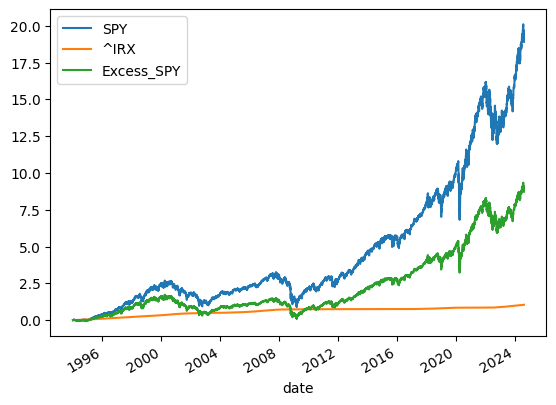

In [56]:
returns = df.copy() 
returns = returns.apply(lambda x: x.astype(float))
returns = returns.apply(lambda x: x + 1)
returns = returns.cumprod()
returns = returns.apply(lambda x: x - 1)
returns.plot()

In [57]:
df['Excess_SPY'] = df['SPY'] - df['^IRX']
df.head()

,SPY,^IRX,Excess_SPY
date,,,
1994-01-04,0.004035,0.000122,0.003913
1994-01-05,0.002009,0.000122,0.001888
1994-01-06,0.000000,0.000121,-0.000121
1994-01-07,0.006016,0.000119,0.005897
1994-01-10,0.011960,0.000119,0.011841


## Historic VaR

In [79]:
rets = df.copy()
rets['Shifted_SPY'] = rets['Excess_SPY'].shift(1) 
rets

,SPY,^IRX,Excess_SPY,Shifted_SPY
date,,,,
1994-01-04,0.004035,0.000122,0.003913,NaN
1994-01-05,0.002009,0.000122,0.001888,0.003913
1994-01-06,0.000000,0.000121,-0.000121,0.001888
1994-01-07,0.006016,0.000119,0.005897,-0.000121
1994-01-10,0.011960,0.000119,0.011841,0.005897
...,...,...,...,...
2024-07-29,0.000588,0.000204,0.000384,0.010995
2024-07-30,-0.005066,0.000204,-0.005270,0.000384
2024-07-31,0.016255,0.000204,0.016051,-0.005270


,SPY,^IRX,Excess_SPY,Shifted_SPY,historic_VaR_5%
date,,,,,
2001-01-02,-0.018104,0.000225,-0.018329,-0.019157,-0.017699
2001-01-03,0.048035,0.000219,0.047815,-0.018329,-0.017794
2001-01-04,-0.010764,0.000208,-0.010972,0.047815,-0.017792
2001-01-05,-0.032643,0.000197,-0.032840,-0.010972,-0.017789
2001-01-08,0.007741,0.000200,0.007540,-0.032840,-0.017858
...,...,...,...,...,...
2024-07-29,0.000588,0.000204,0.000384,0.010995,-0.018511
2024-07-30,-0.005066,0.000204,-0.005270,0.000384,-0.018510
2024-07-31,0.016255,0.000204,0.016051,-0.005270,-0.018510


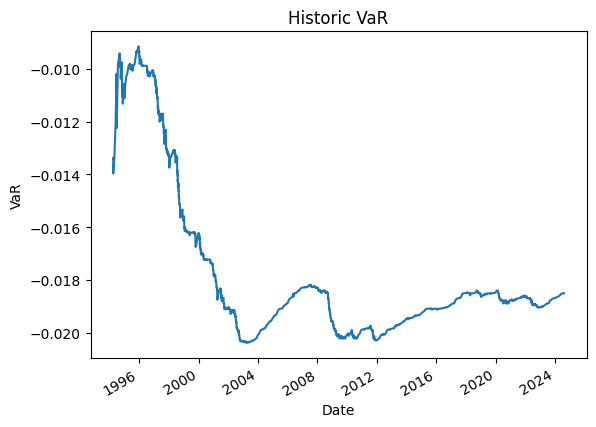

In [80]:
min_periods = 60
var_quantile = 0.05

rets['historic_VaR_5%'] = rets['Shifted_SPY'].expanding(min_periods = min_periods).quantile(var_quantile) 
# use the previous day returns as the var to prevent forward looking bias 

rets['historic_VaR_5%'].plot(title = 'Historic VaR', ylabel = 'VaR', xlabel = 'Date')
rets_trunc = rets.loc['2001-01-01':]
rets_trunc

In [81]:
rets_trunc['Return < VaR'] = rets_trunc['Excess_SPY'] < rets_trunc['historic_VaR_5%']
rets_trunc['Return < VaR'].value_counts()

/var/folders/qq/h84pzsw93xbd60q11ssc5v640000gn/T/ipykernel_1077/1652638961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rets_trunc['Return < VaR'] = rets_trunc['Excess_SPY'] < rets_trunc['historic_VaR_5%']


Return < VaR
False    5639
True      288
Name: count, dtype: int64

In [82]:
hit_ratio = rets_trunc['Return < VaR'].value_counts(normalize=True)[True] 
hit_ratio_error = abs(hit_ratio / var_quantile - 1)
print(f"Hit Ratio = {hit_ratio* 100}")
print(f"Hit Ratio Error = {hit_ratio_error* 100}")

# If hit ratio < q, VaR estimate is overestimating risk. Else, underestimating risk 

Hit Ratio = 4.859119284629661
Hit Ratio Error = 2.8176143074067905


#### What drawbacks do you see in this historic VaR?

Empirical estimation lacks statistical power compared to parametric estimation. When using empirical VaR, only a small sample portion is used to estimate the VaR for the desired quantile. Parametric approaches use the whole sample to calculate volatility, then estimate VaR.

This difference is more significant when we adjust the VaR period based on market changes. For example, if we focus on the last 20 days instead of five years, empirical VaR may rely on a single data point. In contrast, parametric methods estimate volatility over the 20 days, offering more statistically robust results.

Thus, while parametric methods may introduce bias (e.g., assuming normality), they provide better precision, particularly for small samples.

Calculating VaR with a normal distribution is also easier.

Generally, parametric VaR outperforms empirical VaR.

The same holds for CVaR: parametric CVaR provides more statistical significance than its empirical counterpart.

#### Rolling compared to Expanding
- Does not consider considerably old data which might be prior to a structural change.
- Has a hard threshold of which data is important and which is not important to calculate the VaR: using rolling window, datapoints extremely sensitive in the VaR calculation are removed from the calculation once they become old enough (before the rolling start).



In [132]:
window = 252 

def historical_rolling_var(return_series: pd.Series, percentile, window_size) -> pd.Series:
    return return_series.rolling(window=window_size).quantile(percentile)

def historical_expanding_var(return_series: pd.Series, percentile, window_size) -> pd.Series:
    return return_series.expanding(window_size).quantile(percentile)



In [121]:
COLORS = ["blue", "red", "orange"]

def plot_var_graph(var_returns, original_returns): 
    
    plt.figure(figsize=(20, 10))
    plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)
    plt.plot(
        var_returns.dropna().index,
        var_returns,
        color=COLORS[0],
        label='Historical VaR'
    )
    plt.plot(
        original_returns.dropna().index,
        original_returns.dropna(),
        color=COLORS[2],
        label="Excess SPY Returns",
        alpha=.2
    )

    excess_returns_surpass_var = (
        original_returns.loc[
         original_returns < var_returns]
    )
    
    plt.plot(
        excess_returns_surpass_var.index,
        excess_returns_surpass_var.values,
        linestyle="",
        marker="o",
        color=COLORS[1],
        label=f"Return < Historical VaR",
        markersize=1.5
    )
    
    plt.ylim(min(original_returns), 0.01)
    plt.legend() 
    plt.show()


<Axes: xlabel='date'>

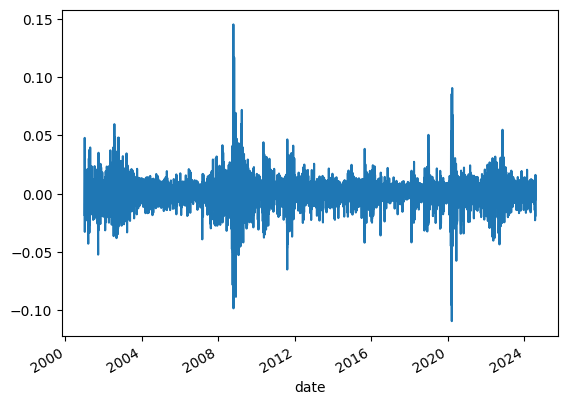

In [106]:
rets['Excess_SPY'].loc['2001-01-01':].plot()

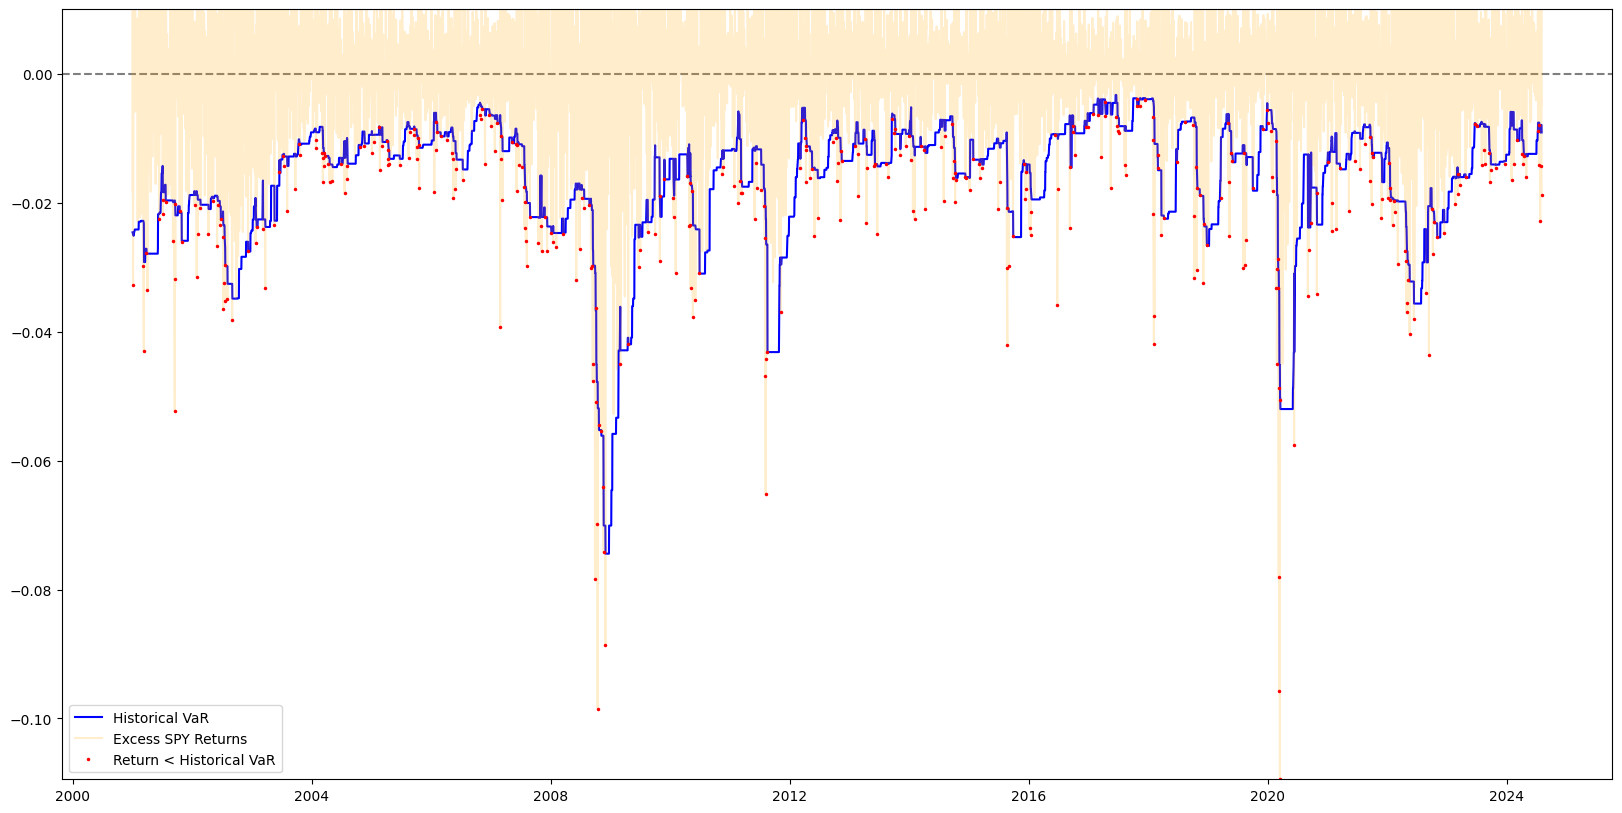

In [122]:
rolling_var = historical_rolling_var(rets['Shifted_SPY'], var_quantile, min_periods)
plot_var_graph(rolling_var.loc['2001-01-01':], rets['Excess_SPY'].loc['2001-01-01':])


## Volatility Estimates

In [208]:
# Calculating volatilities 
def expanding_vol(return_series: pd.Series, window: int) -> pd.Series:
    return np.sqrt((return_series ** 2).expanding(window).mean())

def rolling_vol(return_series: pd.Series, window: int) -> pd.Series:
    return np.sqrt((return_series ** 2).rolling(window).mean())

def calc_ewma_volatility(excess_returns: pd.Series, theta : float = 0.94, initial_vol : float = .2 / np.sqrt(252)) -> pd.Series:
    var_t0 = initial_vol ** 2
    ewma_var = [var_t0]
    for i in range(len(excess_returns.index)):
        new_ewma_var = ewma_var[-1] * theta + (excess_returns.iloc[i] ** 2) * (1 - theta)
        ewma_var.append(new_ewma_var)
    ewma_var.pop(0) # Remove var_t0
    ewma_vol = [np.sqrt(v) for v in ewma_var]
    return pd.Series(ewma_vol, index=excess_returns.index)

In [321]:
min_periods = 60

def calc_var_cvar(returns, window, shift, percentile, z_score = None, normal_vol_formula = False, ewma_theta = 0.94, 
                  ewma_initial_vol = 0.2 / np.sqrt(252), cut_off_date = None, return_hit_ratio = True, 
                  filter_first_hit_ratio_date = "2001-01-01"):

    
    if window is None: 
        window = 60 
    z_score = norm.ppf(percentile) if z_score is None else z_score

    summary = pd.DataFrame({})

    # Returns are already shifted here 
    summary[f'Returns'] = returns
    
    # VaR
    summary[f'Expanding {window:.0f} Historical VaR ({percentile:.2%})'] = historical_rolling_var(returns, percentile, window)
    summary[f'Rolling {window:.0f} Historical VaR ({percentile:.2%})'] = historical_expanding_var(returns, percentile, window)

    # Volatility
    
    if normal_vol_formula:
        summary[f'Expanding {window:.0f} Volatility'] = returns.expanding(window).std()
        summary[f'Rolling {window:.0f} Volatility'] = returns.rolling(window).std()
    else:
        summary[f'Expanding {window:.0f} Volatility'] = np.sqrt((returns ** 2).expanding(window).mean())
        summary[f'Rolling {window:.0f} Volatility'] = np.sqrt((returns ** 2).rolling(window).mean())
        
    summary[f'EWMA {ewma_theta:.2f} Volatility'] = calc_ewma_volatility(returns.dropna(), theta=ewma_theta, initial_vol=ewma_initial_vol)


    
    # Parametric VaR with the statistical distribution
    
    summary[f'Expanding {window:.0f} Parametric VaR ({percentile:.2%})'] = summary[f'Expanding {window:.0f} Volatility'] * z_score
    summary[f'Rolling {window:.0f} Parametric VaR ({percentile:.2%})'] = summary[f'Rolling {window:.0f} Volatility'] * z_score
    summary[f'EWMA {ewma_theta:.2f} Parametric VaR ({percentile:.2%})'] = summary[f'EWMA {ewma_theta:.2f} Volatility'] * z_score

    if cut_off_date is not None:
        summary = summary.loc[summary.index > cut_off_date]

    hit_ratio = pd.DataFrame()

    if return_hit_ratio:
        shift_stats = [
            f'Expanding {window:.0f} Historical VaR ({percentile:.2%})',
            f'Rolling {window:.0f} Historical VaR ({percentile:.2%})',
            f'Expanding {window:.0f} Parametric VaR ({percentile:.2%})',
            f'Rolling {window:.0f} Parametric VaR ({percentile:.2%})',
            f'EWMA {ewma_theta:.2f} Parametric VaR ({percentile:.2%})',
        ]
        summary_shift = summary.copy()
        summary_shift[shift_stats] = summary_shift[shift_stats].shift()
        if filter_first_hit_ratio_date:
            if isinstance(filter_first_hit_ratio_date, (datetime.date, datetime.datetime)):
                filter_first_hit_ratio_date = filter_first_hit_ratio_date.strftime("%Y-%m-%d")
            summary_shift = summary_shift.loc[filter_first_hit_ratio_date:]
        summary_shift = summary_shift.dropna(axis=0)
        summary_shift[shift_stats] = summary_shift[shift_stats].apply(lambda x: (x - summary_shift['Returns']) > 0)
        hit_ratio = pd.DataFrame(summary_shift[shift_stats].mean(), columns=['Hit Ratio'])
        hit_ratio['Hit Ratio Error'] = (hit_ratio['Hit Ratio'] - percentile) / percentile
        hit_ratio['Hit Ratio Absolute Error'] = abs(hit_ratio['Hit Ratio Error'])
        hit_ratio = hit_ratio.sort_values('Hit Ratio Absolute Error')

    summary[f'Expanding {window:.0f} Historical CVaR ({percentile:.2%})'] = returns.expanding(window).apply(lambda x: x[x < x.quantile(percentile)].mean())
    summary[f'Rolling {window:.0f} Historical CVaR ({percentile:.2%})'] = returns.rolling(window).apply(lambda x: x[x < x.quantile(percentile)].mean())
    summary[f'Expanding {window:.0f} Parametrical CVaR ({percentile:.2%})'] = - norm.pdf(z_score) / percentile * summary[f'Expanding {window:.0f} Volatility']
    summary[f'Rolling {window:.0f} Parametrical CVaR ({percentile:.2%})'] = - norm.pdf(z_score) / percentile * summary[f'Rolling {window:.0f} Volatility']
    summary[f'EWMA {ewma_theta:.2f} Parametrical CVaR ({percentile:.2%})'] = - norm.pdf(z_score) / percentile * summary[f'EWMA {ewma_theta:.2f} Volatility']

    
    return summary, hit_ratio
    

# summary, hit_ratio = calc_var_cvar(rets['Shifted_SPY'], window = min_periods, shift = 1, percentile = var_quantile, ewma_theta = 0.94)

# summary[["Expanding 60 Historical VaR (5.00%)", "Rolling 60 Historical VaR (5.00%)"]].plot()
# hit_ratio

# Parameteric 
min_periods = 252
summary, hit_ratio = calc_var_cvar(rets['Shifted_SPY'],window=252,
    percentile=.05,
    ewma_theta=.94,
    ewma_initial_vol=.2/np.sqrt(252),
    filter_first_hit_ratio_date="2001-01-01",
    z_score=-1.65,
    return_hit_ratio=True,
    shift=1,)
summary[[f"Expanding {min_periods} Parametric VaR (5.00%)", f"Rolling {min_periods} Parametric VaR (5.00%)", f"EWMA {0.94} Parametric VaR (5.00%)"]].tail()
hit_ratio

,Hit Ratio,Hit Ratio Error,Hit Ratio Absolute Error
Rolling 252 Historical VaR (5.00%),0.048591,-0.028176,0.028176
Rolling 252 Parametric VaR (5.00%),0.052640,0.052809,0.052809
Expanding 252 Historical VaR (5.00%),0.052809,0.056184,0.056184
Expanding 252 Parametric VaR (5.00%),0.046229,-0.075418,0.075418
EWMA 0.94 Parametric VaR (5.00%),0.059727,0.194533,0.194533


In [309]:
summary[["Expanding 252 Parametric VaR (5.00%)", "Rolling 252 Parametric VaR (5.00%)", "EWMA 0.94 Parametric VaR (5.00%)"]].tail(3)

,Expanding 252 Parametric VaR (5.00%),Rolling 252 Parametric VaR (5.00%),EWMA 0.94 Parametric VaR (5.00%)
date,,,
2024-07-31,-0.019653,-0.011983,-0.013286
2024-08-01,-0.019654,-0.012098,-0.014423
2024-08-02,-0.019654,-0.012185,-0.015141


In [296]:
summary, hit_ratio = calc_var_cvar(rets['Shifted_SPY'], window = min_periods, shift = 1, percentile = var_quantile, ewma_theta = 0.94, cut_off_date = '2021-01-01')
hit_ratio

,Hit Ratio,Hit Ratio Error,Hit Ratio Absolute Error
EWMA 0.94 Parametric VaR (5.00%),0.061111,0.222222,0.222222
Rolling 60 Historical VaR (5.00%),0.038889,-0.222222,0.222222
Rolling 60 Parametric VaR (5.00%),0.062222,0.244444,0.244444
Expanding 60 Parametric VaR (5.00%),0.035556,-0.288889,0.288889
Expanding 60 Historical VaR (5.00%),0.072222,0.444444,0.444444


-1.6448536269514729


<Axes: xlabel='date'>

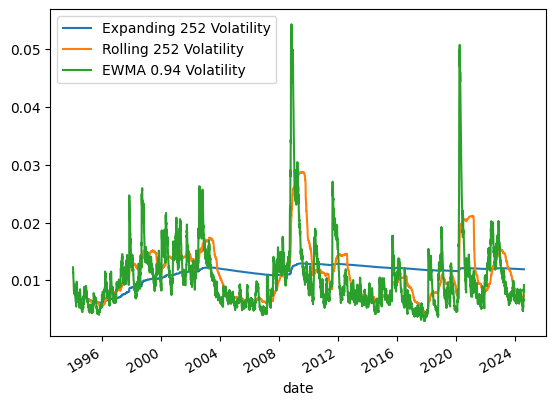

In [245]:
min_periods = 252
summary, hit_ratio = calc_var_cvar(rets['Shifted_SPY'], window = min_periods, shift = 1, percentile = var_quantile, ewma_theta = 0.94)

summary[[f"Expanding {min_periods} Volatility", f"Rolling {min_periods} Volatility", f"EWMA {0.94} Volatility"]].plot()


<Axes: xlabel='date'>

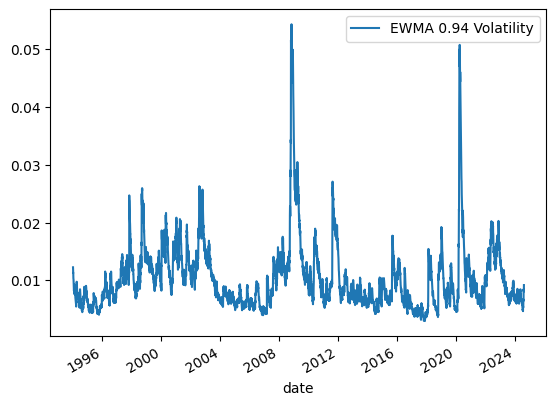

In [213]:
summary[[f"EWMA {0.94} Volatility"]].plot()


EWMA
- For EWMA, a higher theta means that more weight is given to the previous ewma, makes the returns more homogeneous. For smaller thetas, it focuses on the returns and their more recent periods. 
Therefore, a bigger theta leads to EWMA becoming more similar to rolling variance
- It has considers volatility clusters. Days with high volatility are generally followed by other days with high volatility which is easily captured by the EWMA  

In [297]:
# Parameteric 
min_periods = 252
summary, hit_ratio = calc_var_cvar(rets['Shifted_SPY'], window = min_periods, z_score = -1.65, shift = 1, percentile = 0.05, ewma_theta = 0.94)
summary[[f"Expanding {min_periods} Parametric VaR (5.00%)", f"Rolling {min_periods} Parametric VaR (5.00%)", f"EWMA {0.94} Parametric VaR (5.00%)"]].tail()

,Expanding 252 Parametric VaR (5.00%),Rolling 252 Parametric VaR (5.00%),EWMA 0.94 Parametric VaR (5.00%)
date,,,
2024-07-29,-0.019655,-0.012033,-0.013951
2024-07-30,-0.019654,-0.012012,-0.013527
2024-07-31,-0.019653,-0.011983,-0.013286
2024-08-01,-0.019654,-0.012098,-0.014423
2024-08-02,-0.019654,-0.012185,-0.015141


<Axes: xlabel='date'>

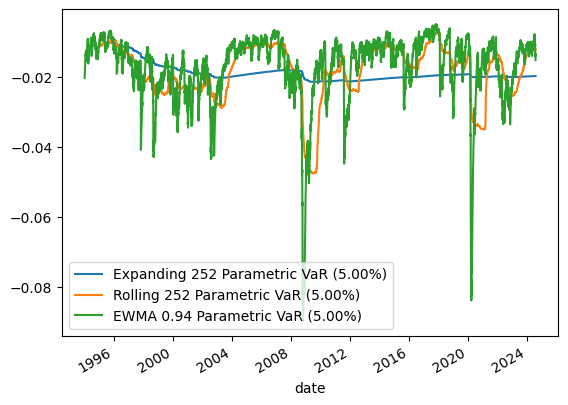

In [256]:
summary[[f"Expanding {min_periods} Parametric VaR (5.00%)", f"Rolling {min_periods} Parametric VaR (5.00%)", f"EWMA {0.94} Parametric VaR (5.00%)"]].plot()

In [298]:
hit_ratio

,Hit Ratio,Hit Ratio Error,Hit Ratio Absolute Error
Rolling 252 Historical VaR (5.00%),0.048591,-0.028176,0.028176
Rolling 252 Parametric VaR (5.00%),0.052640,0.052809,0.052809
Expanding 252 Historical VaR (5.00%),0.052809,0.056184,0.056184
Expanding 252 Parametric VaR (5.00%),0.046229,-0.075418,0.075418
EWMA 0.94 Parametric VaR (5.00%),0.059727,0.194533,0.194533


# cVaR

In [328]:
import re 
def historical_expanding_cvar(return_series: pd.Series, percentile: float = .05) -> pd.Series:
    return return_series.expanding(252).apply(lambda x: x[x < x.quantile(percentile)].mean())

def historical_rolling_cvar(return_series: pd.Series, percentile: float = .05) -> pd.Series:
    return return_series.rolling(252).apply(lambda x: x[x < x.quantile(percentile)].mean())

summary, hit_ratio = calc_var_cvar(rets['Shifted_SPY'], window = min_periods, z_score = -1.65, shift = 1, percentile = 0.05, ewma_theta = 0.94)
spy_cvar = summary.loc[:, lambda df: df.columns[df.columns.map(lambda x: bool(re.search("CVaR", x)))]].loc["2001-01-01":]

<Axes: xlabel='date'>

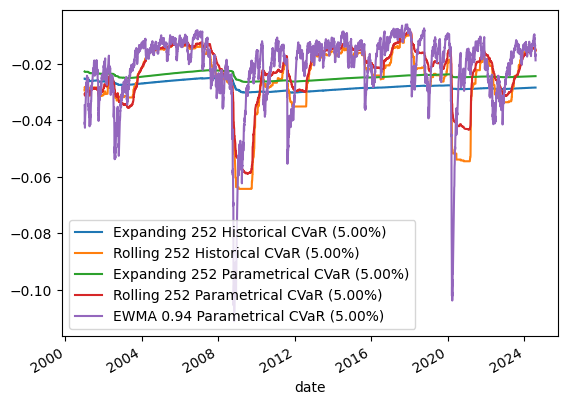

In [329]:
spy_cvar.plot()